In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def distribution_timeseries_plot(data, ts, station, pollutant, start, end):

    plt.style.use('ggplot')

    dates = [date.strftime('%Y-%m-%d') for date in pd.date_range(start=start, end=end, freq='M').tolist()]
    xticks = np.linspace(0, len(ts[pollutant]), len(dates))

    fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

    fig.suptitle(pollutant, fontsize=16, fontweight='bold')

    axs[0].set_title(pollutant + ' Distribution')
    sns.distplot(data[pollutant], ax=axs[0])    

    axs[1].set_title(pollutant + ' 2016-2020 - ' + station.NameStation)

    axs[1].plot(ts[pollutant])
    axs[1].set_xticks(xticks)
    axs[1].set_xticklabels(dates)
    axs[1].tick_params(axis='x', rotation=270)
    axs[1].set_ylabel(pollutant + ' (µg/m³)')

    plt.show()

In [3]:
# settings
pollutants = ['NO2', 'NOx', 'PM2.5', 'PM10']
start = 'March 2019'
end = 'July 2020'

path = 'D:/thesis/data/daily/'

In [4]:
# stations registry
registry = pd.read_csv('./data/registry.csv')

In [5]:
all_pollutants = lambda group: set(pollutants) <= set(group['Pollutant'])
only_pollutants = lambda row: row['Pollutant'].isin(pollutants) 

active_stations = lambda row: pd.isna(row['DateStop'])

filtered_registry = registry[active_stations].groupby('IDStation').filter(all_pollutants)[only_pollutants].sort_values(by='IDStation')

station = filtered_registry.iloc[0]

In [6]:
print(station)

Unnamed: 0                     803
IDSensor                     17122
IDStation                      548
Pollutant                    PM2.5
NameStation    Milano - via Senato
Altitude                     118.0
Province                        MI
City                        Milano
DateStart               2012-09-04
DateStop                       NaN
Latitude                 45.470499
Longitude                  9.19746
Name: 802, dtype: object


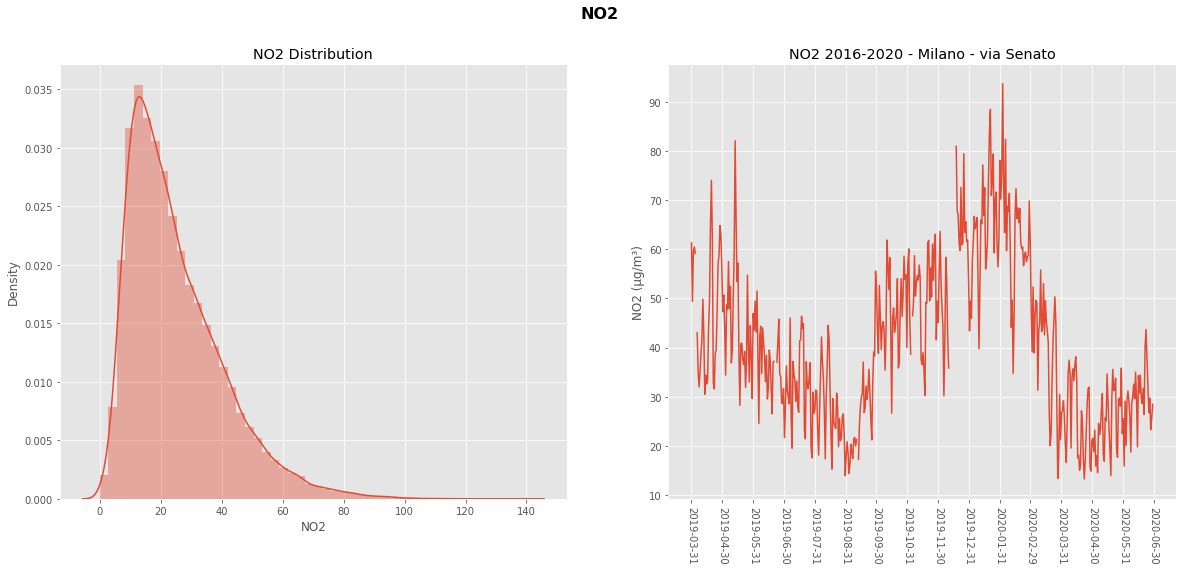

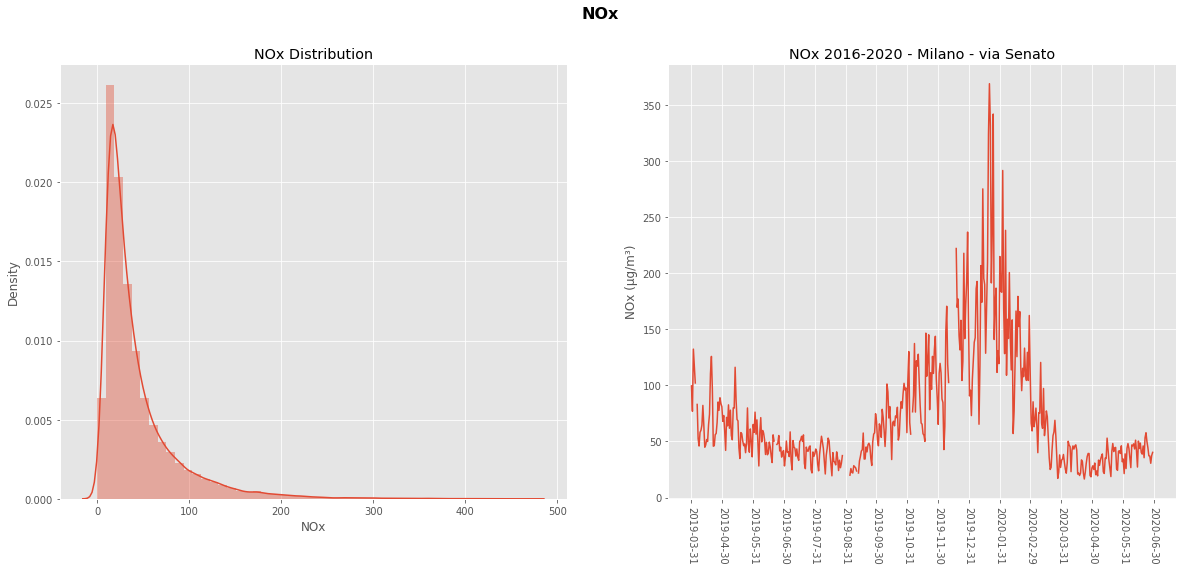

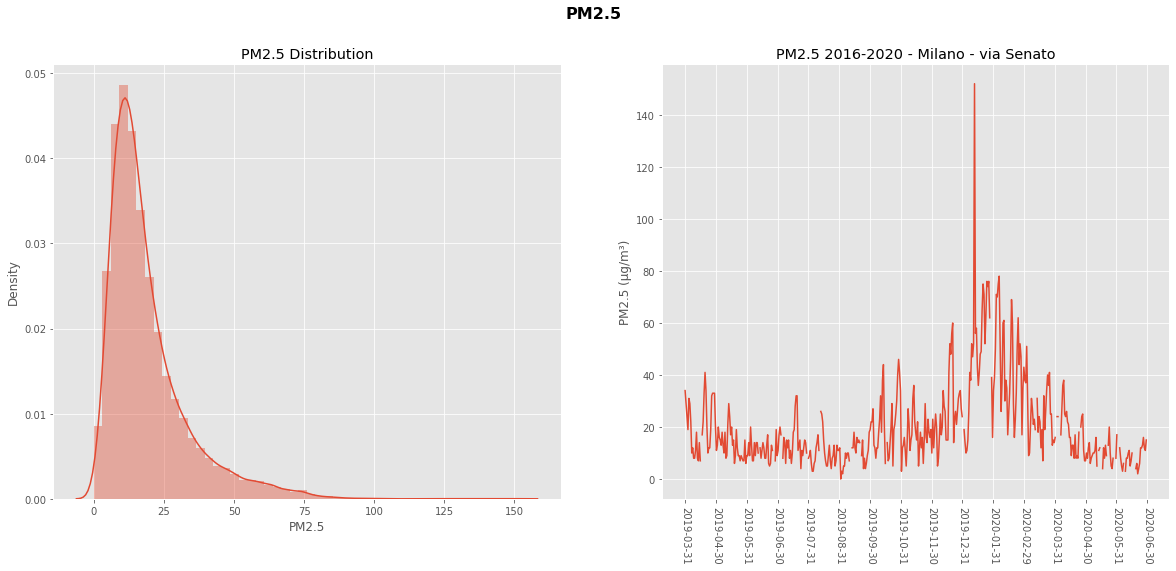

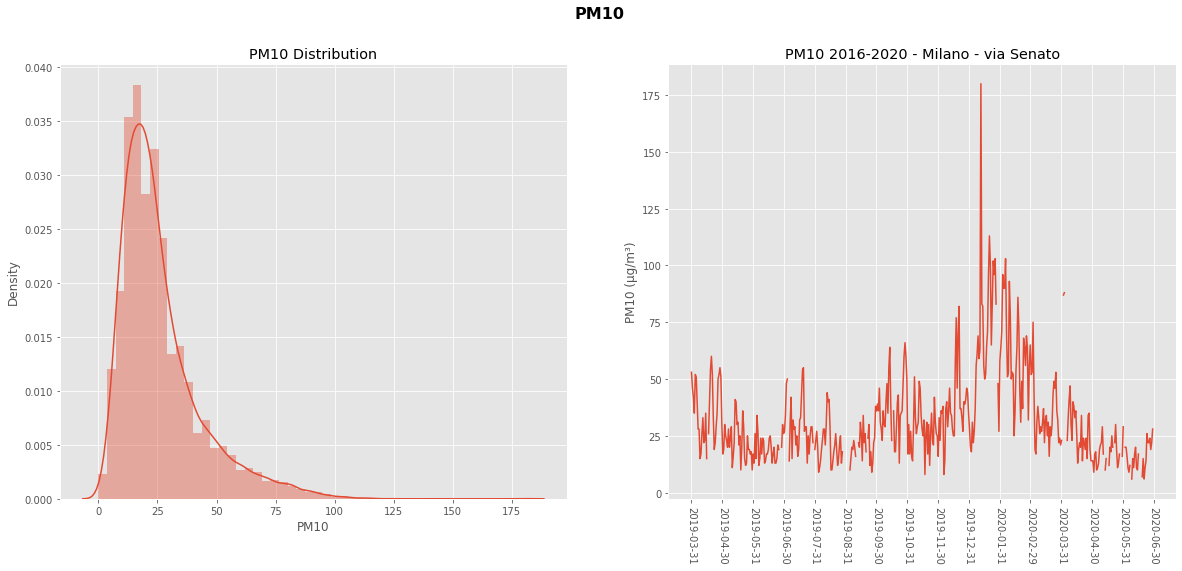

In [7]:
tss = []

for pollutant in pollutants:

    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    # read csv data
    data =  pd.read_csv(path + '{}_compressed.csv'.format(pollutant))

    # clean missing values and negative outliers
    # data = data[(pd.notna(data[pollutant]) & (data[pollutant] > 0))]

    data = data[(pd.to_datetime(data['Date']) > start) & (pd.to_datetime(data['Date']) < end)]

    ts = data[data['IDStation'] == station.IDStation][['Date', pollutant]].set_index('Date')

    tss.append(ts)

    distribution_timeseries_plot(data, ts, station, pollutant, start, end)

In [8]:
from itertools import product

def correlation_plot(pollutants, tss):

    plt.style.use('ggplot')

    assert len(tss) == len(pollutants)

    combinations = [(i, j) for (i, j) in product([0, 1, 2, 3], repeat=2)]    

    fig, axs = plt.subplots(nrows=len(tss), ncols=len(tss)-1, figsize=(20, 20))

    fig.suptitle('Pollutants Correlation', fontsize=16, fontweight='bold')

    skip = False
    ni = 1

    for i, j in combinations:

        if i == j: 
            skip = True
            ni = i + 1
        
        else:

            if skip and i == ni:
                skip = False

            plt.sca(axs[i, j-1 if skip else j])

            plt.scatter(tss[i][pollutants[i]], tss[j][pollutants[j]])
            plt.xticks([])
            plt.xlabel(pollutants[i])
            plt.ylabel(pollutants[j])
            plt.yticks([])   

    plt.show()

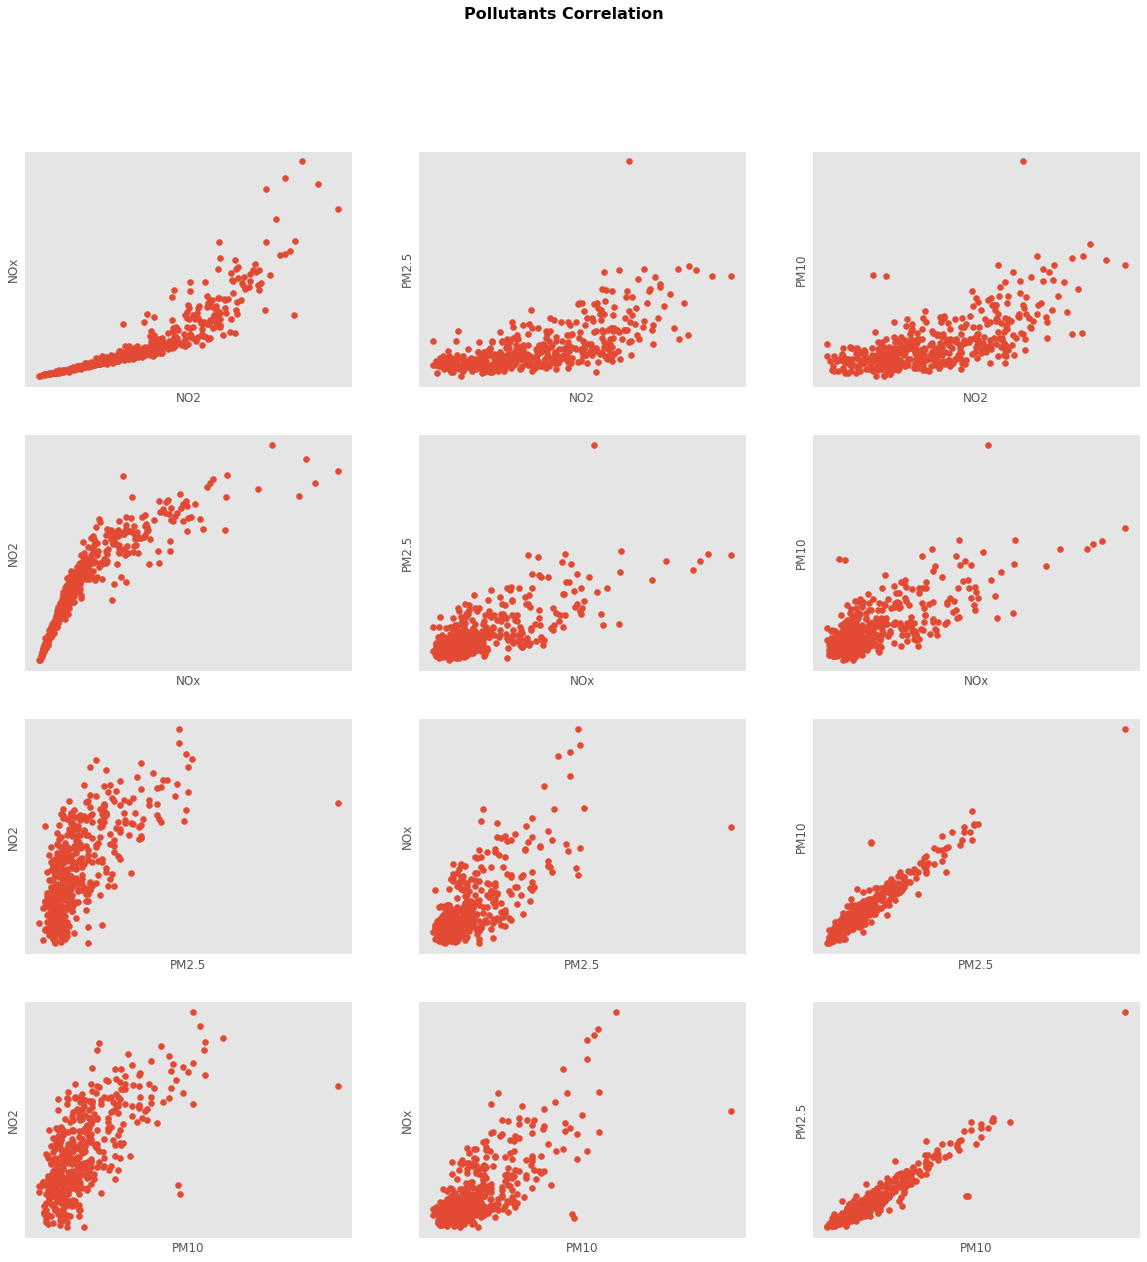

In [9]:
correlation_plot(pollutants, tss)